# 05. TOPICS SPACE

Build the topcics vector space:
- Each dimension = a topic.
- Each work = a vector in this space, where entries correspond to the paper's association with those topics (e.g., 1 for primary topic, 0.5 for secondary, 0.25 for tertiary— or using the score).
- Then reduce this categorical/topic-based space to 2D using UMAP.
- Use topic color overlays for visualization, as before.

In [1]:
import utils

c:\Users\alba.garcia.romo\OneDrive - Accenture\Desktop\alba\TFM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alba.garcia.romo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
df = utils.build_df_with_topics("works_UB_2024_all.json")

In [8]:
print((df.head(2)))
print(len(df))

                                           Work Name  Publication Year  \
0                         Review of Particle Physics              2024   
1  A biological definition of neuronal α-synuclei...              2024   

                                             Authors  \
0  S. Navas, C. Amsler, Th. Gutsche, C. Hanhart, ...   
1  Tanya Simuni, Lana M. Chahine, Kathleen L. Pos...   

                                   Primary Topic  \
0               Dark Matter and Cosmic Phenomena   
1  Parkinson's Disease Mechanisms and Treatments   

                          Subfield                  Field             Domain  \
0  Nuclear and High Energy Physics  Physics and Astronomy  Physical Sciences   
1                        Neurology               Medicine    Health Sciences   

                                            Abstract  \
0  The summarizes much of particle physics and co...   
1                                        no abstract   

                                         

## Domain, field and subfield to the vector representation

In [2]:
import utils

c:\Users\alba.garcia.romo\OneDrive - Accenture\Desktop\alba\TFM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alba.garcia.romo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = utils.build_df_with_topics_extended("works_UB_2024_all.json")
print(df)

                                              Work Name  Publication Year  \
0                            Review of Particle Physics              2024   
1     A biological definition of neuronal α-synuclei...              2024   
2     GWTC-2.1: Deep extended catalog of compact bin...              2024   
3         Robustness and resilience of complex networks              2024   
4         The search for neutrinoless double-beta decay              2024   
...                                                 ...               ...   
7873  Inkjet Printed Perovskite LEDs: Approaches, Li...              2024   
7874  Inkjet-printed FASnI3 photodetectors for flexi...              2024   
7875  Effect of annealing temperature on the propert...              2024   
7876  Nickel-manganese based anodes for efficient el...              2024   
7877  OR30-01 Brown Adipose Tissue as an Endocrine O...              2024   

                                                Authors  \
0     S. Navas, 

In [77]:
df.to_parquet("df_works_UB_2024_with_topics_Alba.parquet", index=False)


In [74]:
df.columns

Index(['Work Name', 'Publication Year', 'Authors', 'Primary Topic', 'Subfield',
       'Field', 'Domain', 'Abstract', 'Topic 1', 'Score 1', 'Domain 1',
       'Field 1', 'Subfield 1', 'Topic 2', 'Score 2', 'Domain 2', 'Field 2',
       'Subfield 2', 'Topic 3', 'Score 3', 'Domain 3', 'Field 3', 'Subfield 3',
       'x_topics', 'y_topics', 'domain_combo'],
      dtype='object')

In [75]:
df_sent = df[['Work Name', 'Publication Year', 'Authors', 'Abstract', 'Topic 1', 'Score 1', 'Domain 1',
       'Field 1', 'Subfield 1', 'Topic 2', 'Score 2', 'Domain 2', 'Field 2',
       'Subfield 2', 'Topic 3', 'Score 3', 'Domain 3', 'Field 3', 'Subfield 3',
       'x_topics', 'y_topics', 'domain_combo']]

In [79]:
df_sent.to_parquet("df_works_UB_2024_with_topics.parquet", index=False)

In [4]:
def build_topic_presence_matrix(df):
    import numpy as np
    import pandas as pd

    # Step 1: Define all label-related columns
    topic_cols = ['Topic 1', 'Topic 2', 'Topic 3']
    subfield_cols = ['Subfield 1', 'Subfield 2', 'Subfield 3']
    field_cols = ['Field 1', 'Field 2', 'Field 3']
    domain_cols = ['Domain 1', 'Domain 2', 'Domain 3']

    # Step 2: Collect all unique values per category
    def clean(values):
        return [v for v in pd.unique(values) if v not in (None, "None", "Unknown")]

    all_topics = clean(df[topic_cols].values.ravel())
    all_subfields = clean(df[subfield_cols].values.ravel())
    all_fields = clean(df[field_cols].values.ravel())
    all_domains = clean(df[domain_cols].values.ravel())

    # Step 3: Create the full list of features
    feature_names = (
        ['TOPIC_' + t for t in all_topics] +
        ['SUBFIELD_' + s for s in all_subfields] +
        ['FIELD_' + f for f in all_fields] +
        ['DOMAIN_' + d for d in all_domains]
    )
    feature_to_index = {name: idx for idx, name in enumerate(feature_names)}

    # Step 4: Initialize count matrix
    num_works = len(df)
    num_features = len(feature_names)
    matrix = np.zeros((num_works, num_features))

    # Step 5: Fill in counts instead of binary flags
    for i, row in df.iterrows():
        for tcol in topic_cols:
            topic = row[tcol]
            if topic not in (None, "None", "Unknown"):
                fname = 'TOPIC_' + topic
                matrix[i, feature_to_index[fname]] += 1

        for scol in subfield_cols:
            subfield = row[scol]
            if subfield not in (None, "None", "Unknown"):
                fname = 'SUBFIELD_' + subfield
                matrix[i, feature_to_index[fname]] += 1

        for fcol in field_cols:
            field = row[fcol]
            if field not in (None, "None", "Unknown"):
                fname = 'FIELD_' + field
                matrix[i, feature_to_index[fname]] += 1

        for dcol in domain_cols:
            domain = row[dcol]
            if domain not in (None, "None", "Unknown"):
                fname = 'DOMAIN_' + domain
                matrix[i, feature_to_index[fname]] += 1

    # Step 6: Wrap in DataFrame
    matrix_df = pd.DataFrame(matrix, columns=feature_names)
    return matrix_df



In [5]:
df_topics = build_topic_presence_matrix(df)
print(df_topics)

      TOPIC_Dark Matter and Cosmic Phenomena  \
0                                        1.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        1.0   
...                                      ...   
7873                                     0.0   
7874                                     0.0   
7875                                     0.0   
7876                                     0.0   
7877                                     0.0   

      TOPIC_Computational Physics and Python Applications  \
0                                                   1.0     
1                                                   0.0     
2                                                   0.0     
3                                                   0.0     
4                                                   0.0     
...                                                 ...  

In [80]:
df_topics.to_parquet("df_topic_embeddings_UB_2024.parquet", index=False)

In [7]:
# some checks
import numpy as np

# dimensions
print(df.shape[0] == df_topics.shape[0])  

# naming
expected_prefixes = ['TOPIC_', 'SUBFIELD_', 'FIELD_', 'DOMAIN_']
print(all(any(col.startswith(prefix) for prefix in expected_prefixes) for col in df_topics.columns)) 

# binary variables
print(np.isin(df_topics.values, [0, 1]).all())  

# examples
i = 0  # Index of the work to check
print("ORIGINAL WORK INFO")
print(df.loc[i, ['Topic 1', 'Topic 2', 'Topic 3', 
                 'Subfield 1', 'Subfield 2', 'Subfield 3', 
                 'Field 1', 'Field 2', 'Field 3', 
                 'Domain 1', 'Domain 2', 'Domain 3']])

print("\nMATRIX NON-ZERO FEATURES FOR WORK", i)
nonzero_features = df_topics.loc[i][df_topics.loc[i] != 0]
for feature, value in nonzero_features.items():
    print(f"{feature}: {value}")





True
True
False
ORIGINAL WORK INFO
Topic 1                        Dark Matter and Cosmic Phenomena
Topic 2           Computational Physics and Python Applications
Topic 3       Particle physics theoretical and experimental ...
Subfield 1                      Nuclear and High Energy Physics
Subfield 2                              Artificial Intelligence
Subfield 3                      Nuclear and High Energy Physics
Field 1                                   Physics and Astronomy
Field 2                                        Computer Science
Field 3                                   Physics and Astronomy
Domain 1                                      Physical Sciences
Domain 2                                      Physical Sciences
Domain 3                                      Physical Sciences
Name: 0, dtype: object

MATRIX NON-ZERO FEATURES FOR WORK 0
TOPIC_Dark Matter and Cosmic Phenomena: 1.0
TOPIC_Computational Physics and Python Applications: 1.0
TOPIC_Particle physics theoretical a

In [1]:
import utils
import pandas as pd

c:\Users\alba.garcia.romo\OneDrive - Accenture\Desktop\alba\TFM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alba.garcia.romo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df_topics = pd.read_parquet(r"01. data\df_topic_embeddings_UB_2024.parquet")
print(df_topics)

      TOPIC_Dark Matter and Cosmic Phenomena  \
0                                        1.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        1.0   
...                                      ...   
7873                                     0.0   
7874                                     0.0   
7875                                     0.0   
7876                                     0.0   
7877                                     0.0   

      TOPIC_Computational Physics and Python Applications  \
0                                                   1.0     
1                                                   0.0     
2                                                   0.0     
3                                                   0.0     
4                                                   0.0     
...                                                 ...  

In [6]:
data_map = utils.create_data_map(15, 0.1, df_topics)

c:\Users\alba.garcia.romo\OneDrive - Accenture\Desktop\alba\TFM\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alba.garcia.romo\OneDrive - Accenture\Desktop\alba\TFM\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
df_ub = utils.build_df_with_topics_extended("works_UB_2024_all.json")
print(df_ub)

                                              Work Name  Publication Year  \
0                            Review of Particle Physics              2024   
1     A biological definition of neuronal α-synuclei...              2024   
2     GWTC-2.1: Deep extended catalog of compact bin...              2024   
3         Robustness and resilience of complex networks              2024   
4         The search for neutrinoless double-beta decay              2024   
...                                                 ...               ...   
7873  Inkjet Printed Perovskite LEDs: Approaches, Li...              2024   
7874  Inkjet-printed FASnI3 photodetectors for flexi...              2024   
7875  Effect of annealing temperature on the propert...              2024   
7876  Nickel-manganese based anodes for efficient el...              2024   
7877  OR30-01 Brown Adipose Tissue as an Endocrine O...              2024   

                                                Authors  \
0     S. Navas, 

In [11]:
df_extra_data_ub = utils.preprocess_df_extra_data(df_ub)
print(df_extra_data_ub)

               Domain_1           Domain_2           Domain_3  \
0     Physical Sciences  Physical Sciences  Physical Sciences   
1       Health Sciences    Health Sciences      Life Sciences   
2     Physical Sciences  Physical Sciences  Physical Sciences   
3     Physical Sciences  Physical Sciences    Social Sciences   
4     Physical Sciences  Physical Sciences  Physical Sciences   
...                 ...                ...                ...   
7873  Physical Sciences  Physical Sciences            Unknown   
7874  Physical Sciences            Unknown            Unknown   
7875  Physical Sciences            Unknown            Unknown   
7876  Physical Sciences  Physical Sciences            Unknown   
7877    Health Sciences            Unknown            Unknown   

                    Field_1                Field_2                Field_3  \
0     Physics and Astronomy       Computer Science  Physics and Astronomy   
1                  Medicine               Medicine           Neur

In [17]:
import datamapplot
import numpy as np

def create_datamapplot_customized(data_map, df_extra_data, embedding_model, n_neighbors, university):
    #open_alex_data_map = np.load("openalex_data_map.npy", allow_pickle=True)
    open_alex_topic_layers = []
    for layer_num in range(4):
        open_alex_topic_layers.append(
        np.load(f"openalex_layer{layer_num}_cluster_labels.npy", allow_pickle=True)
        )
    #print(open_alex_topic_layers)

    openalex_hover_data = np.load("openalex_hover_data.npy", allow_pickle=True)

    badge_css = """
        border-radius:8px;
        width:fit-content;
        max-width:70%;
        margin:2px;
        padding: 2px 8px 2px 8px;
        font-size: 8pt;
    """
    hover_text_template = f"""
    <div>
        <div style="font-size:10pt;padding:2px;">{{hover_text}}</div>
        <div style="background-color:{{color_1}};color:#fff;{badge_css}">{{Field_1_New}}</div>
        <div style="background-color:{{color_2}};color:#fff;{badge_css}">{{Field_2_New}}</div>
        <div style="background-color:{{color_3}};color:#fff;{badge_css}">{{Field_3_New}}</div>
    </div>
    """

    # Create the interactive plot
    plot = datamapplot.create_interactive_plot(
        data_map,
        open_alex_topic_layers[1],
        open_alex_topic_layers[2],
        open_alex_topic_layers[3],
        # open_alex_topic_layers[0], # dont use the primary topic for the visualization
        # masked_layers[3],
        # masked_layers[2],
        # masked_layers[1],
        hover_text = openalex_hover_data,
        initial_zoom_fraction=0.95,
        font_family="Playfair Display SC",
        title= f"OpenAlex {university} Landscape",
        sub_title= f"A data map of papers from {university} in 2024",
        on_click="window.open(`http://google.com/search?q=\"{hover_text}\"`)",
        enable_search=True,
        darkmode=True,
        #inline_data=False,
        #offline_data_prefix="openalex_gallery",
        # cluster_boundary_polygons=True, # boundries are not fine enough
        # cluster_boundary_line_width=1,
        # polygon_alpha=1.9
        # use_medoids=True # does not work
        # cmap = custom_cmap,
        # palette_hue_shift=-0, # rotates color palette
        # palette_hue_radius_dependence=1, # =1 is default, more hue to separate clusters
        extra_point_data=df_extra_data,
        hover_text_html_template=hover_text_template,
        histogram_data= df_extra_data['Field_1'],
        histogram_n_bins= df_extra_data['Field_1'].nunique(),
        histogram_settings={
            "histogram_title": "Primary Field",
            "histogram_width": 500,
            "histogram_height": 100,
            "histogram_log_scale": False,
            "histogram_bin_fill_color": "#6baed6",
            "histogram_bin_selected_fill_color": "#2171b5",
            "histogram_bin_unselected_fill_color": "#c6dbef"
        }
    )
    plot.save(f"openalex_{university}_24_{embedding_model}_{n_neighbors}_neighbors.html")
    #print(plot)
    return plot

<InteractiveFigure width=100% height=800>
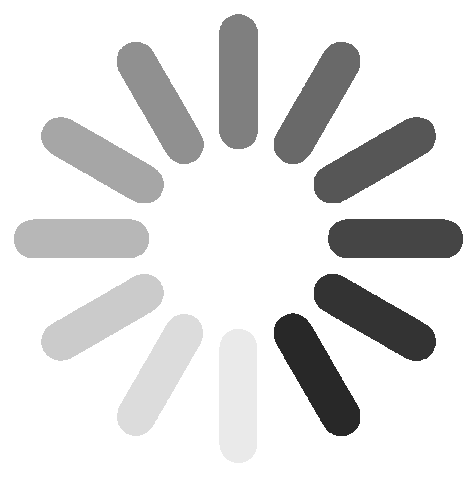

In [18]:
create_datamapplot_customized(data_map, df_extra_data_ub, "topics", '15', 'UB')

In [ ]:
utils.save_coordinates(df_topics, data_map, "topics")
df_topics.to_parquet("df_topic_embeddings_UB_2024.parquet", index=False)

   TOPIC_Dark Matter and Cosmic Phenomena  \
0                                     1.0   
1                                     0.0   

   TOPIC_Computational Physics and Python Applications  \
0                                                1.0     
1                                                0.0     

   TOPIC_Particle physics theoretical and experimental studies  \
0                                                1.0             
1                                                0.0             

   TOPIC_Parkinson's Disease Mechanisms and Treatments  \
0                                                0.0     
1                                                1.0     

   TOPIC_Neurological disorders and treatments  \
0                                          0.0   
1                                          1.0   

   TOPIC_Autism Spectrum Disorder Research  \
0                                      0.0   
1                                      1.0   

   TOPIC_Pulsars and Grav

                                           Work Name  Publication Year  \
0                         Review of Particle Physics              2024   
1  A biological definition of neuronal α-synuclei...              2024   

                                             Authors  \
0  S. Navas, C. Amsler, Th. Gutsche, C. Hanhart, ...   
1  Tanya Simuni, Lana M. Chahine, Kathleen L. Pos...   

                                   Primary Topic  \
0               Dark Matter and Cosmic Phenomena   
1  Parkinson's Disease Mechanisms and Treatments   

                          Subfield                  Field             Domain  \
0  Nuclear and High Energy Physics  Physics and Astronomy  Physical Sciences   
1                        Neurology               Medicine    Health Sciences   

                                            Abstract  \
0  The summarizes much of particle physics and co...   
1                                        no abstract   

                                         

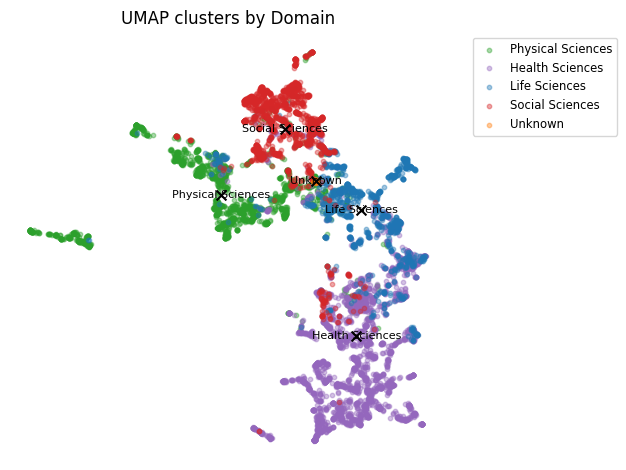

In [20]:
utils.save_coordinates(df_ub, data_map, "topics")
topics_analysis = utils.compute_cluster_spread(df_ub, "x_topics", "y_topics", label_col='Domain', plot=True)

The above plot is colored by the Domain of the primary topic. Modify the plot so it show the domains from the three topics.

In [21]:
def compute_cluster_spread_multidomain(df, x_col, y_col, domain_cols=['Domain 1', 'Domain 2', 'Domain 3'], plot=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Create composite domain label per work (sorted and joined)
    def combine_domains(row):
        domains = [row[col] for col in domain_cols if row[col] not in (None, "None", "Unknown")]
        #domains = [row[col] for col in domain_cols]
        return " + ".join(sorted(set(domains))) if domains else None

    df = df.copy()
    df['Combined_Domains'] = df.apply(combine_domains, axis=1)

    results = []
    for label in df['Combined_Domains'].dropna().unique():
        group = df[df['Combined_Domains'] == label]
        coords = group[[x_col, y_col]].values
        if len(coords) < 2:
            continue

        centroid = coords.mean(axis=0)
        dists = np.linalg.norm(coords - centroid, axis=1)
        avg_dist = dists.mean()
        std_dev = dists.std()

        results.append({
            'label': label,
            'count': len(coords),
            'centroid_x': centroid[0],
            'centroid_y': centroid[1],
            'avg_dist': avg_dist,
            'std_dev': std_dev
        })

        if plot:
            plt.scatter(coords[:, 0], coords[:, 1], s=10, label=label, alpha=0.4)
            plt.scatter(*centroid, c='black', s=50, marker='x')
            #plt.text(centroid[0], centroid[1], label, fontsize=6, ha='center', va='center', color='black')

    if plot:
        plt.title("UMAP clusters by Combined Domains")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-small')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results).sort_values(by='avg_dist')


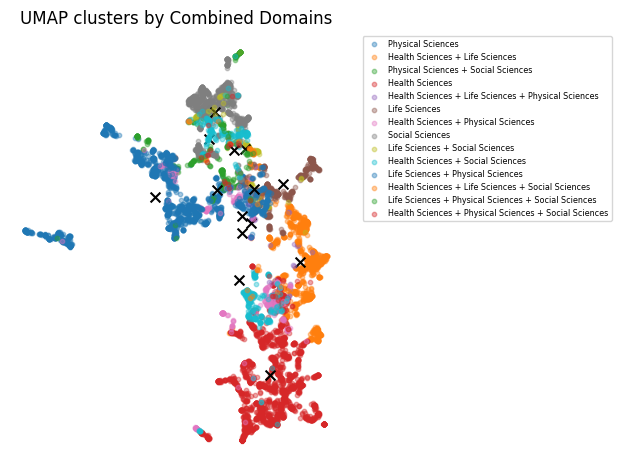

In [23]:
results_df = compute_cluster_spread_multidomain(df_ub, x_col='x_topics', y_col='y_topics')

In [13]:
# COUNT HOW MANY VECTORS HAVE MORE THAN ONE DIFFERENT DOMAIN

def detect_cross_domain_vectors(matrix_df):
    # Step 1: Identify domain-related columns
    domain_cols = [col for col in matrix_df.columns if col.startswith("DOMAIN_")]

    # Step 2: Count how many domain columns are non-zero per row
    domain_counts = (matrix_df[domain_cols] > 0).sum(axis=1)

    # Step 3: Return boolean mask or indices of rows with more than one domain
    cross_domain_mask = domain_counts > 1
    cross_domain_indices = matrix_df.index[cross_domain_mask].tolist()

    return cross_domain_indices, matrix_df.loc[cross_domain_mask]


In [14]:
indices, cross_domain_df = detect_cross_domain_vectors(df_topics)

print(f"Number of works with multiple domains: {len(indices)}")
print("First few cross-domain vectors:")
print(cross_domain_df.head())


Number of works with multiple domains: 2906
First few cross-domain vectors:
    TOPIC_Dark Matter and Cosmic Phenomena  \
1                                      0.0   
3                                      0.0   
5                                      0.0   
9                                      0.0   
11                                     0.0   

    TOPIC_Computational Physics and Python Applications  \
1                                                 0.0     
3                                                 0.0     
5                                                 0.0     
9                                                 0.0     
11                                                0.0     

    TOPIC_Particle physics theoretical and experimental studies  \
1                                                 0.0             
3                                                 0.0             
5                                                 0.0             
9                       

In [15]:
# TO CHECK - COUNT HOW MANY VECTORS HAVE THE SAME DOMAIN FOR ALL THREE TOPICS

def count_same_domain_triplets(matrix_df):
    # Step 1: Get all domain-related columns
    domain_cols = [col for col in matrix_df.columns if col.startswith("DOMAIN_")]

    # Step 2: Identify cross-domain rows using your function
    domain_counts = (matrix_df[domain_cols] > 0).sum(axis=1)
    cross_domain_mask = domain_counts > 1

    # Step 3: Check remaining (non-cross-domain) rows
    single_domain_df = matrix_df[~cross_domain_mask]

    return single_domain_df, len(single_domain_df)



In [16]:
total_non_cross, count_non_cross = count_same_domain_triplets(df_topics)
print(f"Works with 3 same-domain topics: {count_non_cross}")


Works with 3 same-domain topics: 4972


Then, I count the occurrence of any pair of two different domains. The following code will count the occurrence of any pair of different domains. Example:

| Domain 1 | Domain 2 | Domain 3 | Domains used           | Pairs counted                                    |
| -------- | -------- | -------- | ---------------------- | ------------------------------------------------ |
| Life     | Life     | Life     | {Life}                 | None (only one unique domain)                    |
| Life     | Health   | Life     | {Life, Health}         | (Life, Health)                                   |
| Life     | Health   | Social   | {Life, Health, Social} | (Life, Health), (Life, Social), (Health, Social) |


In [17]:
import pandas as pd
import itertools

def compute_domain_cooccurrence(df):
    domain_cols = ['Domain 1', 'Domain 2', 'Domain 3']
    
    # Get all unique valid domains
    all_domains = pd.unique(df[domain_cols].values.ravel())
    all_domains = [d for d in all_domains if d not in (None, "None", "Unknown")]

    # Initialize co-occurrence matrix
    co_matrix = pd.DataFrame(0, index=all_domains, columns=all_domains, dtype=int)

    for _, row in df.iterrows():
        row_domains = [row[col] for col in domain_cols if row[col] not in (None, "None", "Unknown")]
        for d1, d2 in itertools.combinations(set(row_domains), 2):
            co_matrix.at[d1, d2] += 1
            co_matrix.at[d2, d1] += 1  # Symmetric

    return co_matrix


In [18]:
co_matrix = compute_domain_cooccurrence(df)

domains = ["Physical Sciences", "Social Sciences", "Health Sciences", "Life Sciences"]

for domain in domains:
    print("Comparing with domain", {domain})
    if domain in co_matrix:
        print(co_matrix[domain].sort_values(ascending=False).head(10))


Comparing with domain {'Physical Sciences'}
Life Sciences        499
Health Sciences      408
Social Sciences      396
Physical Sciences      0
Name: Physical Sciences, dtype: int64
Comparing with domain {'Social Sciences'}
Health Sciences      542
Physical Sciences    396
Life Sciences        217
Social Sciences        0
Name: Social Sciences, dtype: int64
Comparing with domain {'Health Sciences'}
Life Sciences        1314
Social Sciences       542
Physical Sciences     408
Health Sciences         0
Name: Health Sciences, dtype: int64
Comparing with domain {'Life Sciences'}
Health Sciences      1314
Physical Sciences     499
Social Sciences       217
Life Sciences           0
Name: Life Sciences, dtype: int64


In [19]:
print(co_matrix)

                   Physical Sciences  Health Sciences  Life Sciences  \
Physical Sciences                  0              408            499   
Health Sciences                  408                0           1314   
Life Sciences                    499             1314              0   
Social Sciences                  396              542            217   

                   Social Sciences  
Physical Sciences              396  
Health Sciences                542  
Life Sciences                  217  
Social Sciences                  0  


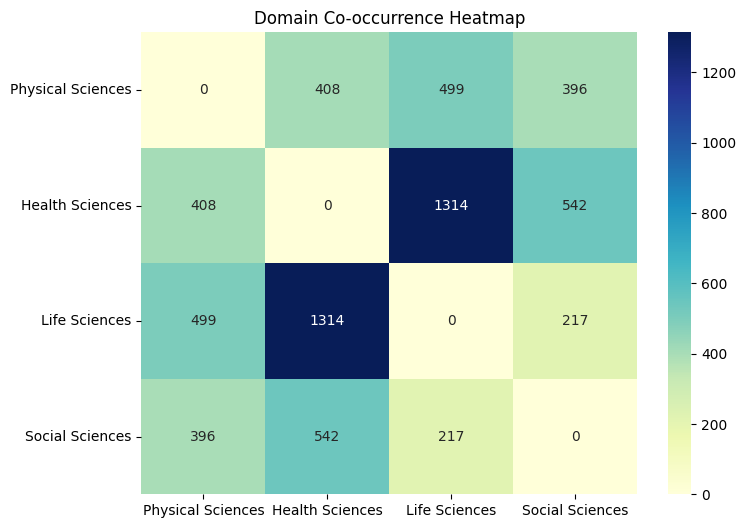

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Domain Co-occurrence Heatmap")
plt.show()

Count the occurrence of all possible combinations of the three domains

In [23]:
from collections import Counter

def count_all_domain_combinations(df, domain_cols=['Domain 1', 'Domain 2', 'Domain 3']):
    combo_counter = Counter()

    for _, row in df.iterrows():
        #domains = [row[col] for col in domain_cols if row[col] not in (None, "None", "Unknown")]
        domains = [row[col] for col in domain_cols]
        
        if domains:
            combo = tuple(sorted(set(domains)))  # Sorted to avoid treating same combos differently
            combo_counter[combo] += 1

    # Convert to a sorted DataFrame for display
    combo_df = pd.DataFrame([
        {"Domain Combination": " + ".join(combo), "Count": count}
        for combo, count in combo_counter.items()
    ]).sort_values(by="Count", ascending=False).reset_index(drop=True)

    return combo_df

In [24]:
domain_combos_df = count_all_domain_combinations(df)
print(domain_combos_df)

                                   Domain Combination  Count
0                                     Health Sciences   1782
1                                   Physical Sciences   1198
2                     Health Sciences + Life Sciences   1114
3                                     Social Sciences    672
4                   Health Sciences + Social Sciences    415
5                                       Life Sciences    375
6                           Social Sciences + Unknown    366
7                   Life Sciences + Physical Sciences    352
8                 Physical Sciences + Social Sciences    312
9                           Health Sciences + Unknown    275
10                Health Sciences + Physical Sciences    253
11                        Physical Sciences + Unknown    186
12                    Life Sciences + Social Sciences    108
13  Health Sciences + Life Sciences + Physical Sci...    102
14  Health Sciences + Life Sciences + Social Sciences     67
15                      

In [25]:
import matplotlib.pyplot as plt

def plot_domain_combinations(combo_df, top_n=20):
    top_combos = combo_df.head(top_n)
    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_combos["Domain Combination"], top_combos["Count"], color='skyblue')
    plt.xlabel("Number of Works")
    plt.title(f"Domain Combinations")
    plt.gca().invert_yaxis()  # Highest on top

    # Add labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 5, bar.get_y() + bar.get_height()/2,
                 f'{int(width)}', va='center')

    plt.tight_layout()
    plt.show()

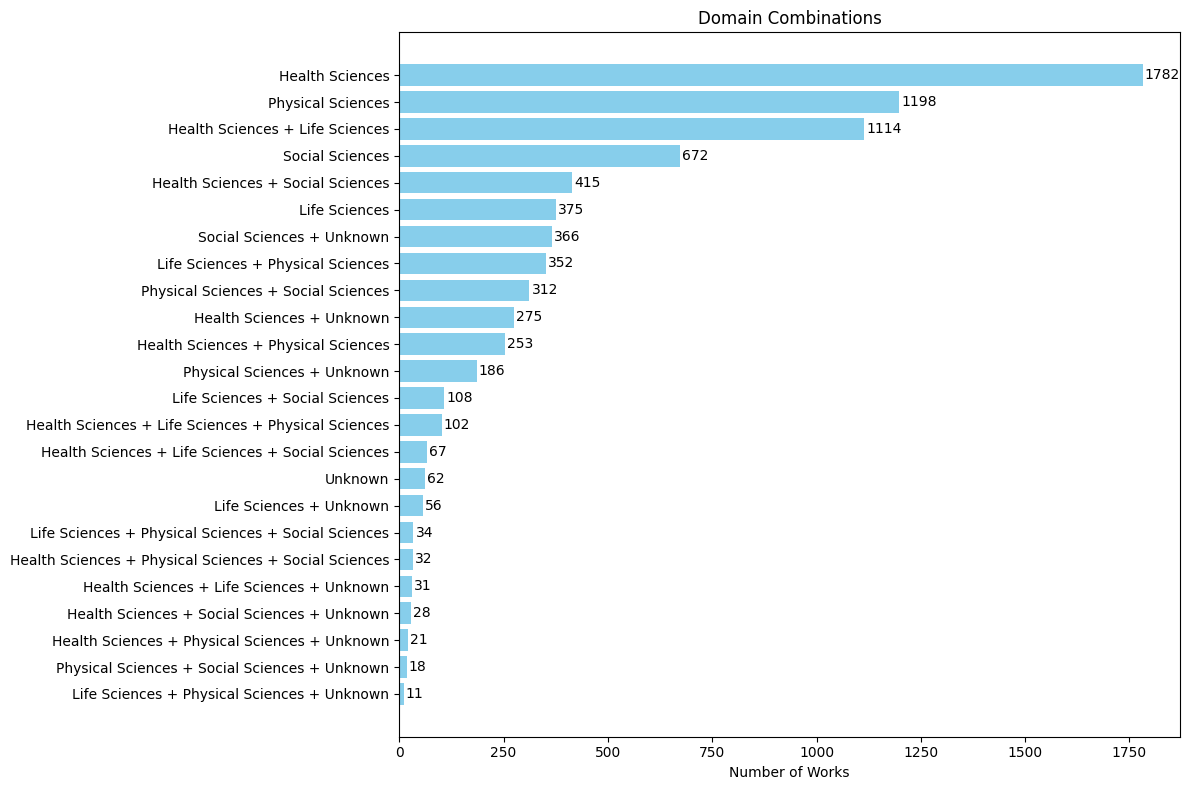

In [26]:
plot_domain_combinations(domain_combos_df, top_n=24)

<Axes: xlabel='Count', ylabel='Domain Combination'>

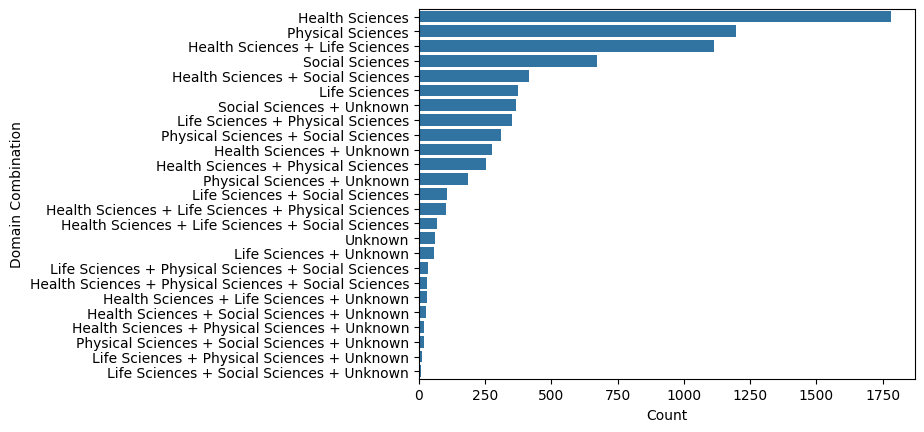

In [27]:
import seaborn as sns

sns.barplot(domain_combos_df, x="Count", y="Domain Combination", orient="h")

### Clustering metrics in topic space

In [28]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import mutual_info_score, adjusted_rand_score

# https://www.geeksforgeeks.org/clustering-metrics/

models = ['topics']
#models = ['st', 'nomic', 'specter']

labels = df['Domain'].astype(str).values # domain of primary topic
print(labels.shape)

for model in models:
    print(f"\nresults of model: {model}")
    X = df[[f"x_{model}", f"y_{model}"]].values

    # Silhouette Score: 1 is better (range: -1 to 1)
    silhouette = silhouette_score(X, labels)

    # Davies-Bouldin Index: lower is better
    davies_bouldin = davies_bouldin_score(X, labels)

    # Calinski-Harabasz Index: higher is better
    calinski_harabasz = calinski_harabasz_score(X, labels)

    #-> cannot do it, compares labels true with labels pred
    # Adjusted Rand Index (ARI): 1 is better (range: -1 to 1) 
    #ari = adjusted_rand_score(X, labels)
    # Mutual Information: higher is better
    #mi = mutual_info_score(X, labels)

    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    #print(f"Adjusted Rand Index: {ari:.2f}")
    #print(f"Mutual Information (MI): {mi:.2f}")

(7878,)

results of model: topics
Silhouette Score: 0.1170
Davies-Bouldin Index: 1.0722
Calinski-Harabasz Index: 3619.0762
